In [1]:
pip install natasha

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")
bert = AutoModel.from_pretrained("sberbank-ai/ruBert-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np

In [4]:
# Загрузка предварительно подготовленного датафрейма
df_time_news = pd.read_csv("df_time_news.csv")  # датасет с курсами и новостями, сохраненный из предыдущего эксперимента
df_time_news

,date,title,Close,target,lag_1,lag_2,lag_3,sma_5,delta_week
0,2020-01-10,Иран заявил о готовности отправить черные ящик...,60.9418,1,60.9418,61.5955,61.9555,61.73192,-1.6490
1,2020-01-13,Макрон и Путин решили сохранить ядерную сделку...,61.2725,1,61.2725,60.9418,61.5955,61.51042,-1.1075
2,2020-01-17,Россия ответила Германии на заявления об убито...,61.4780,1,61.4780,61.2725,60.9418,61.44866,-0.3088
3,2020-01-20,Боевики попытались атаковать российскую авиаба...,61.6000,1,61.6000,61.4780,61.2725,61.37756,-0.3555
4,2020-01-22,Сенаторов США научили бороться с назойливыми ж...,62.0285,1,62.0285,61.6000,61.4780,61.46416,0.4330
...,...,...,...,...,...,...,...,...,...
793,2024-06-19,Церемония встречи Путина и Ким Чен Ына началас...,83.5000,1,83.5000,86.5000,89.0250,87.38000,-6.8750
794,2024-06-20,Генсек НАТО отреагировал на договор России и С...,87.1850,1,87.1850,83.5000,86.5000,87.08200,-1.4900
795,2024-06-21,Бастрыкин рассказал про планы нацистов истреби...,89.0000,0,89.0000,87.1850,83.5000,87.04200,-0.2000
796,2024-06-24,Пентагон спрогнозировал напряженность отношени...,87.4500,0,87.4500,89.0000,87.1850,86.72700,-1.5750


In [5]:
import re
import warnings

import nltk
import numpy as np
import pandas as pd
from datasets import load_dataset
from natasha import Doc, MorphVocab, NewsEmbedding, NewsMorphTagger, Segmenter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("stopwords")

warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# === Предобработка текста (лемматизация на русском через Natasha) ===
segmenter = Segmenter()  # Разделяет текст на предложения и токены
emb = NewsEmbedding()  # Эмбеддинги для новостных текстов
morph_tagger = NewsMorphTagger(emb)  # Определяет часть речи и морфологические признаки
morph_vocab = MorphVocab()  # Используется для лемматизации
stop_words = set(stopwords.words("russian"))  # Русские стоп-слова из NLTK


# === Функция предобработки текста ===
def preprocess_text(text):
    # Приводим к нижнему регистру и удаляем всё, кроме русских букв и пробелов
    text = re.sub(r"[^а-яёА-ЯЁ\\s]", " ", text.lower())

    # Обрабатываем текст с помощью Natasha
    doc = Doc(text)
    doc.segment(segmenter)  # Токенизация
    doc.tag_morph(morph_tagger)  # Морфологическая разметка

    lemmas = []
    for token in doc.tokens:
        # Лемматизируем, если у токена есть морфология
        if token.pos and token.feats:
            lemma = morph_vocab.lemmatize(token.text, token.pos, token.feats)
            # Убираем стоп-слова и слишком короткие леммы
            if lemma not in stop_words and len(lemma) > 2:
                lemmas.append(lemma)

    # Возвращаем текст из лемм
    return " ".join(lemmas)

In [7]:
# Применяем предобработку к заголовкам: очистка и лемматизация
df_time_news["clean_title"] = df_time_news["title"].apply(preprocess_text)

# Просматриваем первые строки полученного датафрейма
df_time_news.head()

,date,title,Close,target,lag_1,lag_2,lag_3,sma_5,delta_week,clean_title
0,2020-01-10,Иран заявил о готовности отправить черные ящик...,60.9418,1,60.9418,61.5955,61.9555,61.73192,-1.6490,иран заявить готовность отправить черный ящик ...
1,2020-01-13,Макрон и Путин решили сохранить ядерную сделку...,61.2725,1,61.2725,60.9418,61.5955,61.51042,-1.1075,макрон путин решить сохранить ядерный сделка и...
2,2020-01-17,Россия ответила Германии на заявления об убито...,61.4780,1,61.4780,61.2725,60.9418,61.44866,-0.3088,россия ответить германии заявление убить берли...
3,2020-01-20,Боевики попытались атаковать российскую авиаба...,61.6000,1,61.6000,61.4780,61.2725,61.37756,-0.3555,боевик попытаться атаковать российский авиабаз...
4,2020-01-22,Сенаторов США научили бороться с назойливыми ж...,62.0285,1,62.0285,61.6000,61.4780,61.46416,0.4330,сенатор сша научить бороться назойливый журнал...


In [8]:
# Используем df_time_news, как в предыдущих моделях
text_col = "clean_title"
num_cols = ["lag_1", "lag_2", "lag_3", "sma_5", "delta_week"]

class MultiModalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df[text_col].tolist()
        self.numerical = df[num_cols].values.astype(np.float32)
        self.labels = df["target"].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        num = self.numerical[idx]
        label = self.labels[idx]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "numerical": torch.tensor(num),
            "label": torch.tensor(label)
        }
        return item

# Разделение на train/test
split = len(df_time_news) - 200
train_ds = MultiModalDataset(df_time_news.iloc[:split], tokenizer)
test_ds = MultiModalDataset(df_time_news.iloc[split:], tokenizer)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)

In [10]:
class MultiModalModel(nn.Module):
    def __init__(self, bert, num_input_dim=5, hidden_dim=128):
        super().__init__()
        self.bert = bert
        self.linear_num = nn.Sequential(
            nn.Linear(num_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            #nn.Linear(768 + hidden_dim, 2)  # 2 класса
            nn.Linear(768 + hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, numerical):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        num_out = self.linear_num(numerical)
        combined = torch.cat([bert_output, num_out], dim=1)
        logits = self.classifier(combined)
        return logits

model = MultiModalModel(bert).to(device)

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# === Балансировка классов ===
class_counts = np.bincount(df_time_news.iloc[:split]["target"])
weights = torch.tensor([class_counts[1], class_counts[0]], dtype=torch.float32)
weights = weights / weights.sum()  # нормализация
criterion = nn.CrossEntropyLoss(weight=weights.to(device))


# Тренировка на 3 эпохи
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numerical = batch["numerical"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

Epoch 1: 100%|██████████| 75/75 [14:53<00:00, 11.91s/it]


Epoch 1 Loss: 0.7045


Epoch 2: 100%|██████████| 75/75 [14:46<00:00, 11.82s/it]


Epoch 2 Loss: 0.6888


Epoch 3: 100%|██████████| 75/75 [14:35<00:00, 11.68s/it]

Epoch 3 Loss: 0.6809


In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numerical = batch["numerical"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask, numerical)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Отчет
print("\n📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=3))


📋 Classification Report:

              precision    recall  f1-score   support

           0      0.488     0.898     0.632        88
           1      0.763     0.259     0.387       112

    accuracy                          0.540       200
   macro avg      0.625     0.578     0.509       200
weighted avg      0.642     0.540     0.495       200



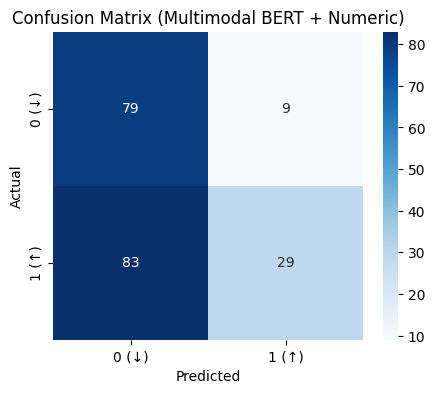

In [13]:
# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0 (↓)", "1 (↑)"], yticklabels=["0 (↓)", "1 (↑)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Multimodal BERT + Numeric)")
plt.show()